In [3]:
import pandas as pd
import numpy as np
import json
import pickle
import seaborn as sns
import networkx as nx
import copy
import matplotlib.pyplot as plt
import math
import os
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1.Load the supplied dataset
We first start by loading supplied datasets.

In [2]:
DATA_PATH = "./MovieSummaries/"

#Path to the referenced dataset
NEW_DATA_PATH = "./ExpandedData/"

#Normalizing the column names of the dataframe
movie_columns = ['WID', 'FID', 'MovieName', 'MovieReleaseDate', 'MovieBoxOfficeRevenue', \
                 'MovieRuntime', 'MovieLanguages', 'MovieCountries', 'MovieGenres']

characters_columns = ['WID','FID','MovieReleaseDate','CharacterName','ActorDOB','ActorGender',\
                      'ActorHeight','ActorEthnicity','ActorName','ActorAgeAtMovieRelease',\
                      'CharacterActorMapID','CharacterID','ActorID']

In [3]:
#Load two dataframes
movies = pd.read_csv(DATA_PATH+"movie.metadata.tsv", sep='\t', names=movie_columns)
characters = pd.read_csv(DATA_PATH+"character.metadata.tsv", sep='\t', names=characters_columns)

## 2.  Basic cleaning
Our research focuses on the evolution of actors, and to facilitate this study, we are meticulously organizing the data across two distinct tables. Initially, we will concentrate on refining the 'characters' dataframe, which is of paramount importance to our analysis.

### 2.1 Characters dataframe

In [4]:
#Checking samples and try to find problems
characters.sample(10)

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID
159687,3479886,/m/09fqgj,2007-08-09,NaN,1982-04-17,F,NaN,NaN,Fuschia Sumner,25.0,/m/0h5qyns,NaN,/m/0h5qynw
129773,15465392,/m/03h44mv,2009-01-22,Lucian,1969-02-05,M,1.75,/m/06gbnc,Michael Sheen,39.0,/m/04ddxd0,/m/0bm5h2,/m/01pkhw
391411,13987477,/m/03cq84w,2007,NaN,1943-01-13,M,2.01,NaN,Richard Moll,63.0,/m/0csc_5r,NaN,/m/03qf9s
265974,2412799,/m/07b9s0,2008-12-19,Sean's Dad,1947-12-29,M,1.88,NaN,Ted Danson,60.0,/m/0h1pgjr,/m/0h1pgjx,/m/01ft2l
112656,5579823,/m/0dtkpg,1995,NaN,1939-09-04,M,NaN,NaN,Bob May,55.0,/m/0cgc6ft,NaN,/m/0gpm3d
163799,2853200,/m/086yst,1991-11-24,Arjun,1970-06-17,M,NaN,NaN,Arvind Swamy,21.0,/m/0k464r,/m/0h73gz0,/m/077215
355633,673903,/m/031txz,1997-03-13,Teddy,1964-09-28,M,NaN,NaN,Brendan Kelly,32.0,/m/0c09v11,/m/0c09v14,/m/0bxxy_
349473,30865328,/m/05rqhv,2005-04-08,NaN,1967-01-24,M,1.77,/m/0x67,Phil LaMarr,38.0,/m/03jtfdb,NaN,/m/01nd6v
386711,1967834,/m/069q4f,1992-02-21,NaN,1947-09-29,M,NaN,NaN,Martin Ferrero,44.0,/m/02tb3fy,NaN,/m/079wyq
22072,17356696,/m/043s9dw,1930-08,NaN,1893-12-12,M,1.65,/m/041rx,Edward G. Robinson,NaN,/m/04dhqnl,NaN,/m/017g2y


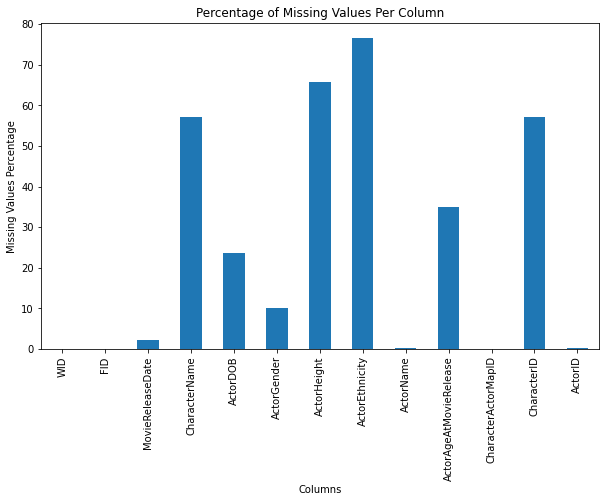

In [5]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (characters.isnull().sum() / len(characters)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

Taking into account the key points from our previous discussion and the questions we aim to investigate, we have performed the following data cleansing tasks:

1. We have eliminated rows where 'ActorName' is missing, as our research is focused on the transformation of actors.
2. We standardized the date format and corrected any inaccuracies within the data.
3. We used the difference between the movie release date and the actor's date of birth to fill in any gaps in the actors' age data.

#### 2.1.1 Remove rows with ActorName of NaN 

In [6]:
characters_drop = characters.dropna(subset=['ActorName']).copy()

#### 2.1.2 Unify the format of the date

Entries where an actor's birth date postdates the release date of the movie are erroneous and should be excised from the dataset.

In [7]:
characters_date_change = characters_drop.copy()
characters_date_change.loc[characters_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
characters_date_change['MovieReleaseDate'] = pd.to_datetime(characters_date_change['MovieReleaseDate'], errors='coerce').dt.year
characters_date_change['ActorDOB'] = pd.to_datetime(characters_date_change['ActorDOB'], errors='coerce').dt.year

#Create a mask to mark rows with a birth date later than the release date (424rows)
mask = characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']

#invalid_rows = characters_data_change[mask]
#print(invalid_rows)

# Delete these rows
characters_date_change = characters_date_change[~mask]

#Check
characters_date_change[characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID


In [8]:
characters_date_change.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449258 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449258 non-null  int64  
 1   FID                     449258 non-null  object 
 2   MovieReleaseDate        273013 non-null  float64
 3   CharacterName           192416 non-null  object 
 4   ActorDOB                329691 non-null  float64
 5   ActorGender             404867 non-null  object 
 6   ActorHeight             154756 non-null  float64
 7   ActorEthnicity          106016 non-null  object 
 8   ActorName               449258 non-null  object 
 9   ActorAgeAtMovieRelease  292360 non-null  float64
 10  CharacterActorMapID     449258 non-null  object 
 11  CharacterID             192424 non-null  object 
 12  ActorID                 449258 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 48.0+ MB


#### 2.1.3.Supplementing missing data on actors' ages with movie release dates - actors' birth dates

In [9]:
# Find rows where age is missing but date of birth and date of appearance are not missing
characters_age_change = characters_date_change.copy()
mask2 = characters_age_change['ActorAgeAtMovieRelease'].isnull() & \
        characters_age_change['ActorDOB'].notnull() & \
        characters_age_change['MovieReleaseDate'].notnull() \


# Calculate age for these rows
characters_age_change.loc[mask2, 'ActorAgeAtMovieRelease'] = (
                                        characters_age_change.loc[mask2, 'MovieReleaseDate'] - \
                                        characters_age_change.loc[mask2, 'ActorDOB']
                                                             )


# Show rows with updated age data（21036 rows updated）
characters_age_change[mask2]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID
86,31983669,/m/0g4_n3m,1931.0,"Tomka Zhigan, leader of the wild boys",1899.0,M,NaN,NaN,Mikhail Zharov,32.0,/m/0g4_ndp,/m/0g4_nbx,/m/07m08h
93,31983669,/m/0g4_n3m,1931.0,NaN,1887.0,M,NaN,NaN,Vladimir Uralsky,44.0,/m/0g4_nfp,NaN,/m/0jt1q2
97,31983669,/m/0g4_n3m,1931.0,Nikolai Sergeiev,1899.0,M,NaN,NaN,Nikolai Batalov,32.0,/m/0g4_nd9,/m/0g4_nbj,/m/0jt1lz
98,17715326,/m/047t9rb,1935.0,NaN,1888.0,M,NaN,NaN,Graham McNamee,47.0,/m/0jz1t0_,NaN,/m/07g4h_
195,14631844,/m/03grb4v,1917.0,NaN,1891.0,M,NaN,NaN,Wallace Reid,26.0,/m/0cg2rbf,NaN,/m/03q8vb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450605,7762741,/m/0kvgqq,1914.0,NaN,1883.0,M,NaN,NaN,Jack Richardson,31.0,/m/09h_33r,NaN,/m/0ks01m
450606,7762741,/m/0kvgqq,1914.0,NaN,1871.0,M,NaN,NaN,Harry von Meter,43.0,/m/09h_33l,NaN,/m/0kr_7z
450607,21975745,/m/05p4tmc,1938.0,NaN,1894.0,M,NaN,NaN,Billy Bletcher,44.0,/m/0gw3w0l,NaN,/m/06f_qn
450611,15567100,/m/03mfb7j,1922.0,NaN,1881.0,M,NaN,NaN,Duke R. Lee,41.0,/m/040nz44,NaN,/m/03c74h7


In [10]:
#Clearing age is negative(199rows,MovieReleaseDate,ActorDOBat least one missing )
negative_age_mask = characters_date_change['ActorAgeAtMovieRelease'] < 0
indices_to_drop = characters_date_change[negative_age_mask].index

#Delete these rows
characters_date_change = characters_date_change.drop(indices_to_drop)

#Check
characters_date_change[characters_date_change['ActorAgeAtMovieRelease'] < 0]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID


### 2.2 Movies Dataframe
Let's move on to the movies dataframe.

In [11]:
#Checking samples and try to find problems
movies.head(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [12]:
import json
#Processing format
movies_format = movies.copy()

movies_format['MovieLanguages'] = movies_format['MovieLanguages'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieCountries'] = movies_format['MovieCountries'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: ",".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].str.split(',')
movies_format.head()

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,[Drama]


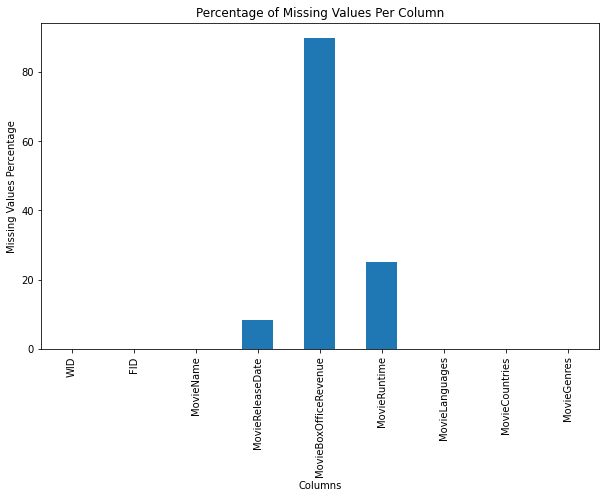

In [13]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (movies_format.isnull().sum() / len(movies)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

To investigate the evolution of actors' roles across different movie genres, we perform the following key operations on the movie dataset:

Quantify the occurrence of genre terms, refine the dataset's format, identify principal genres, and apply additional filters as needed.
Standardize the date formatting and rectify any discrepancies.
Integrate supplementary datasets to compensate for the significant gaps in box office information. Post-processing, introduce new columns to adjust for inflation effects.

#### 2.2.1 Handling the genres

Initially, we assessed the prevalence of different genres, identifying 18 key categories as representative.  
Subsequent to this, through manual review and data visualization techniques, we refined our genre classifications, integrating some categories in alignment with the genre definitions provided by Wikipedia.

In [14]:
#Statistical word frequency
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: x if isinstance(x, list) else [])
categories = movies_format['MovieGenres'].explode().value_counts()
sorted_category_counts = categories.sort_values(ascending=False)
print(sorted_category_counts.head(50))

MovieGenres
Drama                     34007
Comedy                    16349
Romance Film              10234
Black-and-white            9094
Action                     8798
Thriller                   8744
Short Film                 8141
World cinema               7155
Crime Fiction              6948
Indie                      6897
Documentary                5630
Horror                     5280
Silent film                5250
Adventure                  4963
Family Film                4598
Action/Adventure           4561
Comedy film                4362
Musical                    4160
Animation                  3534
Romantic drama             3372
Mystery                    3195
Science Fiction            3052
Fantasy                    2820
Romantic comedy            2680
War film                   2652
Japanese Movies            2322
                           2294
Western                    2226
Crime Thriller             2122
Period piece               1758
Comedy-drama               1

In [15]:
#Further cleaning of MovieGenres accoding to our observation

#Common genres of our selection
selected_genres = ['Comedy', 'Drama', 'Romance', 'Action', 'Thriller', 'Crime', 'Documentary',\
                   'Horror', 'Adventure', 'Musical' , 'Animation', 'Science Fiction', 'Fantasy',\
                   'Western', 'War film', 'Sports', 'Hisorty', 'Detective']

# clean the genre,use deepcopy to make sure there will be no change in previous dataframe
genre = [copy.deepcopy(x) for x in movies_format["MovieGenres"].values]
movie_genres_selected = []

#Unify genres‘ data and filter the “drama” genres
for line in genre:
    selected = []
    for g in line:
        if g in selected_genres:
            selected.append(g)
        elif g in ['Romance Film', 'Romantic drama', 'Romantic comedy']:
            selected.append('Romance')
        elif g in ['Crime Fiction', 'Crime Thriller', 'Crime Drama']:
            selected.append('Crime')
        elif g in ['Action/Adventure']:
            selected.append('Adventure')
            selected.append('Action')
        elif g in ['Black comedy', 'Comedy film', 'Comedy-drama', 'Sex comedy', 'Comedy of manners', 'Musical comedy', 'Horror Comedy', 'Fantasy Comedy']:
            selected.append('Comedy')
        elif g in ['Action Thrillers','Wuxia', 'Martial Arts Film']:
            selected.append('Action')
            selected.append('Thriller')
        elif g in ['Detective fiction']:
            selected.append('Detective')
        elif g in ['Historical drama', 'Historical fiction']:
            selected.append('History')
        elif g in ['Anime']:
            selected.append('Animation')
                
    
    # remove the duplicates and sort list of genres by the initial letter
    sorted_set_genres = sorted(set(selected))
    
    movie_genres_selected.append(sorted_set_genres)
    
movies_genres_filter = movies_format.copy()
movies_genres_filter["MovieGenresSelected"] = movie_genres_selected

In [16]:
# calculate the proportion of empty selected genres
movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) == 0].shape[0]/movies_genres_filter.shape[0]

0.11399420119646199

Our selection can cover 89% of the data.

In [17]:
# drop rows where there is no movie genre selected
movies_genres_clean = movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) > 0].copy()
movies_genres_clean.sample(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected
1205,5566878,/m/0dsxdc,Tortilla Soup,2001-08-24,4574762.0,103.0,English LanguageSpanish Language,United States of America,"[Romantic comedy, Indie, Slice of life story, ...","[Comedy, Drama, Romance]"
7190,1245381,/m/04lrhf,Thumb Wars,1999,NaN,28.0,English Language,United States of America,"[Parody, Short Film, Science Fiction, Adventur...","[Adventure, Comedy, Science Fiction]"
10841,35617134,/m/0jkzzr_,Maa Pelliki Randi,2000,NaN,NaN,Telugu language,India,"[Family Film, Drama]",[Drama]
13081,903159,/m/03ndzs,Spellbound,2002,NaN,97.0,English Language,United States of America,[Documentary],[Documentary]
8049,1781640,/m/05wgg3,Honour Betrayed,NaN,NaN,NaN,,,[Documentary],[Documentary]
78533,7818764,/m/026f3ck,Mrs. Wiggs of the Cabbage Patch,1934,NaN,80.0,English Language,United States of America,"[Comedy, Black-and-white]",[Comedy]
67445,28160641,/m/0cmbtn8,Sentimentalnyy roman,1976,NaN,NaN,,Soviet Union,[Drama],[Drama]
47922,30366109,/m/0g5rqyz,Jeevana Tarangalu,1973,NaN,NaN,Telugu language,India,[Drama],[Drama]
28461,31172989,/m/0gh8t23,Contraband Spain,1955-03-15,NaN,78.0,English LanguageSpanish Language,SpainUnited Kingdom,"[Crime Fiction, Drama]","[Crime, Drama]"
67761,6917005,/m/0gwypk,The Music Man,2003-02-16,NaN,180.0,English Language,United States of America,"[Romance Film, Comedy film, Drama, Family Film...","[Comedy, Drama, Musical, Romance]"


In [18]:
#check
movies_genres_clean[movies_genres_clean["MovieGenresSelected"].map(len) == 0]

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected


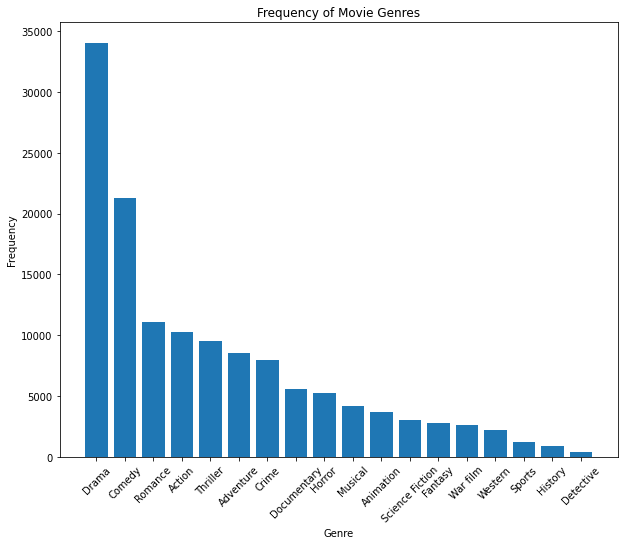

In [19]:
#Counting the frequency of every genre 

genre_counter = Counter()

# Iterate through each list in the column
for genre_list in movies_genres_clean['MovieGenresSelected']:
    genre_counter.update(genre_list)

# Converting word frequency results into a DataFrame
genre_frequency = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting to show word frequency
plt.figure(figsize=(10, 8))
plt.bar(genre_frequency['Genre'], genre_frequency['Frequency'])
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Genres')
plt.xticks(rotation=45)
plt.show()

1. The 'Drama' genre encompasses a wide range, and its prevalence complicates the characterization of an actor's career shifts. Consequently, we will retain 'Drama' only when it is not paired with any other genre.

2. Actors appearing in animated movies mostly partake through voice acting. Given that providing voice for animated action scenes is inherently different from performing in live-action action movies, we have decided to eliminate all rows associated with the animation genre from our database.

In [20]:
genre = [copy.deepcopy(x) for x in movies_genres_clean["MovieGenresSelected"].values]
movie_genres_drama_animation_del = []

# Keeping “Drama” only when drama appears alone, delete entire entry when “animation” exists
for line in genre:
    # If 'Animation' is in the line, do not add the line to the final list
    if 'Animation' in line:
        movie_genres_drama_animation_del.append([])
    else:
        # If 'Drama' is in the line alongside other genres, remove 'Drama'
        if len(line) > 1 and 'Drama' in line:
            line.remove('Drama')
        # Add the modified line to the final list
        movie_genres_drama_animation_del.append(line)

movies_genres_del = movies_genres_clean.copy()
movies_genres_del["MovieGenresFinal"] = movie_genres_drama_animation_del 

In [21]:
#Filter 
movies_genres_del_filter = movies_genres_del[movies_genres_del["MovieGenresFinal"].map(len) > 0].copy()

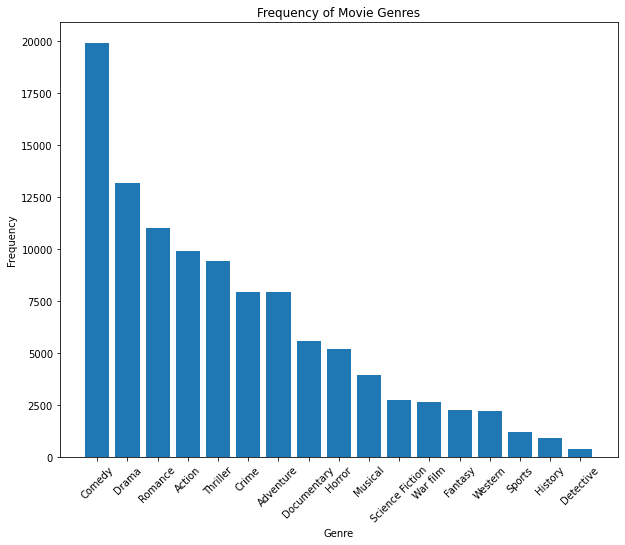

In [22]:
#Counting the frequency of every genre 

genre_counter = Counter()

# Iterate through each list in the column
for genre_list in movies_genres_del["MovieGenresFinal"]:
    genre_counter.update(genre_list)

# Converting word frequency results into a DataFrame
genre_frequency = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting to show word frequency
plt.figure(figsize=(10, 8))
plt.bar(genre_frequency['Genre'], genre_frequency['Frequency'])
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Genres')
plt.xticks(rotation=45)
plt.show()

#### 2.2.2 Unify the date format and deal with the wrong data

In [23]:
#Unify the date format(Harmonization of reservations by year)
movies_date_change = movies_genres_del_filter.copy()
movies_date_change.loc[movies_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
movies_date_change['MovieReleaseDate'] = pd.to_datetime(movies_date_change['MovieReleaseDate'], errors='coerce').dt.year

In [24]:
movies_date_change.head(50)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected,MovieGenresFinal
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]","[Crime, Drama]",[Crime]
2,28463795,/m/0crgdbh,Brun bitter,NaN,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]","[Crime, Drama]",[Crime]
3,9363483,/m/0285_cd,White Of The Eye,NaN,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",[Thriller],[Thriller]
4,261236,/m/01mrr1,A Woman in Flames,NaN,NaN,106.0,German Language,Germany,[Drama],[Drama],[Drama]
5,13696889,/m/03cfc81,The Gangsters,1913.0,NaN,35.0,Silent filmEnglish Language,United States of America,"[Short Film, Silent film, Indie, Black-and-whi...",[Comedy],[Comedy]
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,NaN,86.0,English Language,South Africa,"[Family Film, Fantasy, Adventure, World cinema]","[Adventure, Fantasy]","[Adventure, Fantasy]"
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,106.0,English Language,United States of America,"[Musical, Comedy, Black-and-white]","[Comedy, Musical]","[Comedy, Musical]"
8,9997961,/m/06_y2j7,Contigo y aquí,NaN,NaN,NaN,Spanish Language,Argentina,"[Musical, Drama, Comedy]","[Comedy, Drama, Musical]","[Comedy, Musical]"
9,2345652,/m/075f66,City of the Dead,NaN,NaN,76.0,English Language,United Kingdom,"[Horror, Supernatural]",[Horror],[Horror]


#### 2.2.3 Handling the 'Revenue' column

In [25]:
movies_key = movies_date_change[movies_date_change['MovieBoxOfficeRevenue'].notna()]
movies_key.shape

(7998, 11)

In [26]:
extraMovieBoxOfficeRevenue=pd.read_pickle(NEW_DATA_PATH+"additional_revenue_data.pkl")

# Rename
extraMovieBoxOfficeRevenue.rename(columns={'freebase_movie_id': 'FID'}, inplace=True)
extraMovieBoxOfficeRevenue.rename(columns={'revenue': 'MovieBoxOfficeRevenue'}, inplace=True)
extraMovieBoxOfficeRevenue.head(10)

,FID,MovieBoxOfficeRevenue
0,/m/02pg45,4300000
1,/m/03dymt,12136938
2,/m/0dtfn,775398007
3,/m/01jrbb,940335536
4,/m/0bdjd,677945399
5,/m/0c0zq,356296601
6,/m/01lsl,23217674
7,/m/01m13b,40031879
8,/m/0125xq,263920180
9,/m/0d6b7,650422


In [27]:
# Merge based on FID
movies_revenue_merged_data = pd.merge(movies_date_change,extraMovieBoxOfficeRevenue[['FID', 'MovieBoxOfficeRevenue']], on='FID', how='left')

# Keep original data, append where missing
movies_revenue_merged_data['MovieBoxOfficeRevenue'] = movies_revenue_merged_data.apply(
    lambda row: row['MovieBoxOfficeRevenue_y'] if pd.isna(row['MovieBoxOfficeRevenue_x']) else row['MovieBoxOfficeRevenue_x'], axis=1
)

#Remove duplicates
movies_revenue_merged_data.drop(columns=['MovieBoxOfficeRevenue_x', 'MovieBoxOfficeRevenue_y'], inplace=True)

In [28]:
movies_key2 = movies_revenue_merged_data[movies_revenue_merged_data['MovieBoxOfficeRevenue'].notna()]
movies_key2.shape

(9795, 11)

In [29]:
# Number of supplements
number_supplements = len(movies_key2) - len(movies_key)
number_supplements

1797

In [30]:
# Inflation per country from 1960 to 2021
df_inflation = pd.read_csv(NEW_DATA_PATH+"inflation.csv", header=2)
df_inflation = df_inflation.iloc[:,0:-1]
df_inflation.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,9.158707,5.750981,5.370290,5.250171,6.571396,6.399343,4.720811,4.120246,5.404815,7.240978
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.578375,2.439201,1.758052,2.130268,1.494564,1.764635,1.784050,1.758565,2.492522,3.925603
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,10.277905,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN,NaN


In [31]:
# Inflation in the USA from 1960 to 2021 as the revenue and budget are calculated in US dollars
usa_inflation = df_inflation[df_inflation['Country Code'] == 'USA']

# Create the inflation coefficients per year 
inflation_coef = np.zeros(63)
inflation_coef[0] = 1
for i in range(62):
    year = i + 1960
    inflation_coef[i+1] = inflation_coef[i] * (1 + float(usa_inflation[str(year)].iloc[0])/100)
print(inflation_coef[-1])

9.295703259005146


In [32]:
# Function that gets the coefficient coeff according to the year
def get_inflation(year):
    if isinstance(year, int) :
        x = year-1959
        if x >= 0 and x < len(inflation_coef) :
            return inflation_coef[-1]/inflation_coef[x]
    return float('nan')

# Add the inflation coeff column to the dataframe 
movies_coeff_add = movies_revenue_merged_data.copy()
movies_coeff_add["InflationCoeff"] = movies_coeff_add["MovieReleaseDate"].apply(get_inflation)

In [33]:
movies_revenue_inflation = movies_coeff_add . copy()
movies_revenue_inflation["inflation corrected revenue"] = movies_revenue_inflation['MovieBoxOfficeRevenue'] * movies_revenue_inflation["MovieReleaseDate"].apply(get_inflation)

## 3. Merge two dataframes and load external datasets

We seamlessly integrated the curated datasets of `characters` and `movies`, enriching our analysis with an exciting new dataset that includes:  

1.The pulse of cinema's heart—the IMDB ratings.  
2.The glittering accolades bestowed upon actors at the four major film festivals: Cannes, Berlin, Venice, and the Oscars.  

This treasure trove of information will illuminate our journey as we delve into the catalysts and impacts of actor metamorphoses.

### 3.1 Merge two main dataframes

In [34]:
#merge the processed two dataframes
characters_movies_merge = pd.merge(characters_date_change , movies_date_change, how='inner', on=["WID", "FID", "MovieReleaseDate"])
characters_movies_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        251724 non-null  float64
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                301676 non-null  float64
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

In [35]:
characters_movies_merge[characters_movies_merge["MovieGenresFinal"].isnull()]["MovieGenresFinal"]

Series([], Name: MovieGenresFinal, dtype: object)

In [36]:
#Changing data types to int to harmonize with external datasets and facilitate merging
merge_change_type = characters_movies_merge.copy()
merge_change_type['MovieReleaseDate'] = merge_change_type['MovieReleaseDate'].fillna(0).astype(int)
merge_change_type['ActorDOB'] = merge_change_type['ActorDOB'].fillna(0).astype(int)

merge_change_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        413660 non-null  int64  
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                413660 non-null  int64  
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

Fill in the MovieReleaseDate with the ActorDOB and ActorAgeAtMovieRelease.

In [37]:
# Find rows where MovieReleaseDate is missing ActorDOB and date of appearance are not missing
merge_fill_release_date = merge_change_type.copy()

mask3 = (merge_fill_release_date['MovieReleaseDate'] == 0) & \
        (merge_fill_release_date['ActorAgeAtMovieRelease'].notnull()) & \
        (merge_fill_release_date['ActorDOB'] !=0) \

#Total number of calculations that can be made
true_count = sum(mask3)
print(f"Number of true values in mask3: {true_count}")


Number of true values in mask3: 88477


In [38]:
# Calculate age for these rows
merge_fill_release_date.loc[mask3, 'MovieReleaseDate'] = (
                                        merge_fill_release_date.loc[mask3, 'ActorAgeAtMovieRelease'] + \
                                        merge_fill_release_date.loc[mask3, 'ActorDOB']
                                                             )

In [39]:
# Show rows with updated age data（88618 rows updated）
merge_fill_release_date['MovieReleaseDate'].loc[mask3].astype(int)

32        1987
33        1987
35        1987
36        1982
37        1982
          ... 
413633    1951
413649    2001
413650    2001
413653    2001
413657    1956
Name: MovieReleaseDate, Length: 88477, dtype: int64

### 3.2 Import IMDB rating and the number of votes 

In [40]:
#Read two tables (IMDB ratings and IMDB movies basic info) and merge the desired info together
IMDB_rating = pd.read_csv(NEW_DATA_PATH+'title.ratings.tsv', sep='\t')
IMDB_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In [41]:
IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')
IMDB_name.head()

<ipython-input-41-9fd7d296c54b>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [42]:
#Delete unneeded columns
IMDB_name_delete = IMDB_name[['tconst', 'primaryTitle','startYear']].copy()
IMDB_merge = IMDB_name_delete.merge(IMDB_rating, on='tconst')
IMDB_merge.isna()['tconst'].unique()
IMDB_merge.head()

,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0000001,Carmencita,1894,5.7,2006
1,tt0000002,Le clown et ses chiens,1892,5.8,269
2,tt0000003,Pauvre Pierrot,1892,6.5,1909
3,tt0000004,Un bon bock,1892,5.5,178
4,tt0000005,Blacksmith Scene,1893,6.2,2689


In [43]:
#View startyear data
IMDB_merge['startYear'].unique()

array(['1894', '1892', '1893', '1895', '1896', '1898', '1897', '1900',
       '1899', '1901', '1902', '1903', '1904', '1912', '1907', '1905',
       '1906', '1908', '1910', '1909', '1990', '1914', '1911', '1913',
       '1919', '1916', '1917', '1915', '1918', '1936', '1925', '1922',
       '1920', '1921', '1923', '1924', '2021', '1927', '1929', '2000',
       '1926', '1993', '1935', '1928', '1942', '1930', '1931', '1932',
       '1939', '1937', '1950', '1933', '1938', '1951', '1934', '1945',
       '1946', '1940', '1944', '1949', '1947', '1941', '1952', '1970',
       '1957', '1943', '1959', '1948', '1994', '2001', '1953', '1954',
       '1965', '1983', '1980', '1973', '1961', '1995', '1955', '1962',
       '1958', '1956', '1960', '1977', '1964', '2012', '1967', '1963',
       '1988', '1968', '1971', '1969', '1972', '1966', '1976', '1979',
       '2016', '1974', '1981', '2020', '1978', '1989', '2014', '1975',
       '1986', '1985', '1987', '2010', '2018', '1996', '1992', '2023',
      

In [44]:
# Handling of outliers'\\N'
IMDB_merge['startYear'] = IMDB_merge['startYear'].replace('\\N', 0)

In [45]:
#change its type to int, in order to merge with our datasets
IMDB_merge['startYear'] = IMDB_merge['startYear'].fillna(0).astype(int)

In [46]:
duplicates = IMDB_merge.duplicated(subset=['primaryTitle', 'startYear'], keep=False)

# Filter your DataFrame
duplicate_rows = IMDB_merge[duplicates]
duplicate_rows.head(20)

,tconst,primaryTitle,startYear,averageRating,numVotes
125,tt0000127,Les tribulations d'un concierge,1896,4.4,27
174,tt0000177,The Burglar on the Roof,1898,4.6,249
234,tt0000279,Buffalo Bill's Wild West Parade,1900,4.3,25
235,tt0000280,Buffalo Bill's Wild West Parade,1900,4.6,25
319,tt0000471,Uncle Tom's Cabin,1903,5.2,520
320,tt0000472,Uncle Tom's Cabin,1903,6.3,23
394,tt0000630,Hamlet,1908,2.9,27
469,tt0000754,Romeo and Juliet,1908,7.2,63
588,tt0000950,Macbeth,1909,4.0,16
665,tt0001083,The Violin Maker of Cremona,1909,5.0,145


In [47]:
# Group by 'primaryTitle' and 'startYear' and calculate the mean of 'averageRating' and sum of 'votenum'
new_IMDB_df = IMDB_merge.groupby(['primaryTitle', 'startYear']).agg({
    'averageRating': 'mean',
    'numVotes': 'sum'
}).reset_index()


# Display the first few rows to check
new_IMDB_df.head()

,primaryTitle,startYear,averageRating,numVotes
0,!Next?,1994,5.1,20
1,!Que ve el Bisbe!,2011,6.2,12
2,!Women Art Revolution,2010,6.8,256
3,#,2012,4.4,18
4,#,2014,7.0,6


In [48]:
#Left connection, import movie ratings to our dataframe
characters_movies_IMDBratings_merge = merge_fill_release_date.merge(
    new_IMDB_df,
    left_on=['MovieName', 'MovieReleaseDate'],
    right_on=['primaryTitle', 'startYear'],
    how='left'
)

characters_movies_IMDBratings_merge.head()

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,...,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected,MovieGenresFinal,primaryTitle,startYear,averageRating,numVotes
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0


In [49]:
# Save the required columns
characters_movies_dropUnneed = characters_movies_IMDBratings_merge.drop(['primaryTitle','startYear'], axis=1)

characters_movies_renamed = characters_movies_dropUnneed.rename(
                               columns={'averageRating': 'AverageRating',
                                        'numVotes': 'NumVotes',
                                       })   
characters_movies_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        413660 non-null  int64  
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                413660 non-null  int64  
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

To investigate the prevalence of missing rating data among actors with varying numbers of film appearances.

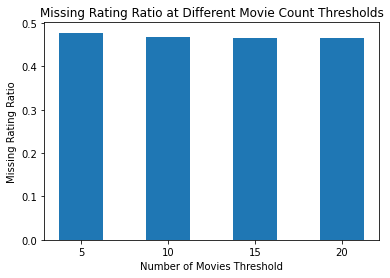

0    0.477519
1    0.468305
2    0.464289
3    0.464367
Name: Missing Ratio, dtype: float64

In [50]:
# Define the movie count thresholds
thresholds = [5, 10, 15, 20]

# Prepare the results dictionary
results = {'Threshold': [], 'Missing Ratio': []}

# Group the dataframe by 'ActorID' and count the number of movies per actor
movie_count_per_actor = characters_movies_renamed.groupby('ActorID').size()

# Loop over the defined thresholds
for threshold in thresholds:
    # Find actors that meet or exceed the threshold
    actors_meet_threshold = movie_count_per_actor[movie_count_per_actor >= threshold].index
    
    # Filter the dataframe to only include these actors
    filtered_df = characters_movies_renamed[characters_movies_renamed['ActorID'].isin(actors_meet_threshold)]
    
    # Calculate the missing ratio for 'averageRating'
    missing_ratio = filtered_df['AverageRating'].isna().sum() / len(filtered_df)
    
    # Add the results to the results dictionary
    results['Threshold'].append(threshold)
    results['Missing Ratio'].append(missing_ratio)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Plot the histogram
plt.bar(results_df['Threshold'], results_df['Missing Ratio'], width=2.5)
plt.xlabel('Number of Movies Threshold')
plt.ylabel('Missing Rating Ratio')
plt.title('Missing Rating Ratio at Different Movie Count Thresholds')
plt.xticks(thresholds)
plt.show()

results_df['Missing Ratio']

#### 3.3 Importing four dataset of actor awards from the four major film festivals

In [51]:
#Importing an organized dataset of actor awards in Cannes
award_columns = ['AwardYear', 'ActorName', 'CharacterName','MovieName']
Cannes = pd.read_csv(NEW_DATA_PATH+'Cannes.csv', sep=',')
Cannes.columns = award_columns
Cannes

,AwardYear,ActorName,CharacterName,MovieName
0,1946,Ray Milland,Don Birnam,The Lost Weekend
1,1949,Edward G. Robinson,Gino Monetti,House of Strangers
2,1951,Michael Redgrave,Andrew Crocker-Harris,The Browning Version
3,1952,Marlon Brando,Emiliano Zapata,Viva Zapata!
4,1955,Spencer Tracy,John J. Macreedy,Bad Day at Black Rock
...,...,...,...,...
177,2010,Juliette Binoche,The Woman,Certified Copy
178,2011,Kirsten Dunst,Justine,Melancholia
179,2012,Cristina Flutur,Alina,Beyond the Hills
180,2012,Cosmina Stratan,Voichita,Beyond the Hills


In [52]:
#Importing an organized dataset of actor awards in Berlin
Berlin = pd.read_csv(NEW_DATA_PATH+'Berlin.csv', sep=',')
Berlin.columns = award_columns
Berlin

,AwardYear,ActorName,CharacterName,MovieName
0,1956,Burt Lancaster,Mike Ribble,Trapeze
1,1957,Pedro Infante,Tizoc,Tizoc
2,1958,Sidney Poitier,Noah Cullen,The Defiant Ones
3,1959,Jean Gabin,Joseph Hughes Guillamume Boutier-Blainville / ...,Archimède le clochard
4,1960,Fredric March,Matthew Harrison Brady,Inherit The Wind
...,...,...,...,...
123,2011,Sareh Bayat,Razieh,A Separation
124,2011,Sarina Farhadi,Termeh,A Separation
125,2011,Kimia Hosseini,Somayeh,A Separation
126,2012,Rachel Mwanza,Komona,War Witch


In [53]:
#Importing an organized dataset of actor awards in Venice
Venice = pd.read_csv(NEW_DATA_PATH+'Venice.csv', sep=',')
Venice.columns = award_columns
Venice

,AwardYear,ActorName,CharacterName,MovieName
0,1932,Fredric March,Dr. Henry Jekyll / Mr. Edward Hyde,Dr. Jekyll and Mr. Hyde
1,1934,Wallace Beery,Pancho Villa,Viva Villa!
2,1935,Pierre Blanchar,Rodion Raskolnikov,Crime and Punishment
3,1936,Paul Muni,Louis Pasteur,The Story of Louis Pasteur
4,1937,Emil Jannings,Matthias Clausen,Der Herrscher
...,...,...,...,...
136,2009,Kseniya Rappoport,Sonia,The Double Hour
137,2010,Ariane Labed,Marina,Attenberg
138,2011,Deanie Ip,Sister Peach,A Simple Life
139,2012,Hadas Yaron,Shira Mendelman,Fill the Void


In [54]:
# Merge Cannes with main dataframe
Cannes_key = Cannes[['ActorName', 'MovieName']]
merged_awards_Cannes = pd.merge(characters_movies_renamed, Cannes_key, on=['ActorName', 'MovieName'], how='left', indicator='Cannes')
merged_awards_Cannes['Cannes'] = (merged_awards_Cannes['Cannes'] == 'both').astype(int)
merged_awards_Cannes.shape

(413660, 24)

In [55]:
# Merge Berlin with main dataframe
Berlin_key = Berlin[['ActorName', 'MovieName']]
merged_awards_Berlin = pd.merge(merged_awards_Cannes, Berlin_key, on=['ActorName', 'MovieName'], how='left', indicator='Berlin')
merged_awards_Berlin['Berlin'] = (merged_awards_Berlin['Berlin'] == 'both').astype(int)
merged_awards_Berlin.shape

(413660, 25)

In [56]:
# Merge Venice with main dataframe
Venice_key = Venice[['ActorName', 'MovieName']]
merged_awards_Venice = pd.merge(merged_awards_Berlin, Venice_key, on=['ActorName', 'MovieName'], how='left', indicator='Venice')
merged_awards_Venice['Venice'] = (merged_awards_Venice['Venice'] == 'both').astype(int)
merged_awards_Venice.shape

(413660, 26)

In [57]:
# Load Oscar Dataset 
Oscar = pd.read_csv(NEW_DATA_PATH+'the_oscar_award.csv', sep=',')
Oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [58]:
#Dealing with irregularities in the Oscar dataset
selected_categories = ["ACTOR", "ACTRESS", "ACTOR IN A SUPPORTING ROLE", 
                       "ACTRESS IN A SUPPORTING ROLE", "ACTOR IN A LEADING ROLE", 
                       "ACTRESS IN A LEADING ROLE"]

selected_rows = Oscar[Oscar['category'].isin(selected_categories)].copy()


selected_rows['Oscar Winner'] = 0
selected_rows['Oscar Nomination'] = 0

selected_rows.loc[selected_rows['winner'], 'Oscar Winner'] = 1
selected_rows.loc[~selected_rows['winner'], 'Oscar Nomination'] = 1

Oscar_key = selected_rows[['name', 'film', 'Oscar Winner', 'Oscar Nomination']]
Oscar_key.columns = ['ActorName', 'MovieName', 'OscarWinner', 'OscarNomination' ]
Oscar_key.head()

,ActorName,MovieName,OscarWinner,OscarNomination
0,Richard Barthelmess,The Noose,0,1
1,Emil Jannings,The Last Command,1,0
2,Louise Dresser,A Ship Comes In,0,1
3,Janet Gaynor,7th Heaven,1,0
4,Gloria Swanson,Sadie Thompson,0,1


In [59]:
#merge Oscar dataset with our main set
merged_awards_Oscar = pd.merge(merged_awards_Venice, Oscar_key, on=['ActorName', 'MovieName'], how='left')
merged_awards_Oscar['OscarWinner'] = merged_awards_Oscar['OscarWinner'].fillna(0).astype(int)
merged_awards_Oscar['OscarNomination'] = merged_awards_Oscar['OscarNomination'].fillna(0).astype(int)
merged_awards_Oscar.shape

(413661, 28)

In [ ]:
# save the dataframe in a binary format
merged_awards_Oscar.to_pickle("./characters_movies.pkl")

## 4. Count movies of each actor

In [3]:
# load the merged dataframe
df = pd.read_pickle("./characters_movies.pkl")
df.head()

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,...,MovieGenres,MovieGenresSelected,MovieGenresFinal,AverageRating,NumVotes,Cannes,Berlin,Venice,OscarWinner,OscarNomination
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,...,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,...,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,...,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,...,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0


In [4]:
df.columns

Index(['WID', 'FID', 'MovieReleaseDate', 'CharacterName', 'ActorDOB',
       'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName',
       'ActorAgeAtMovieRelease', 'CharacterActorMapID', 'CharacterID',
       'ActorID', 'MovieName', 'MovieBoxOfficeRevenue', 'MovieRuntime',
       'MovieLanguages', 'MovieCountries', 'MovieGenres',
       'MovieGenresSelected', 'MovieGenresFinal', 'AverageRating', 'NumVotes',
       'Cannes', 'Berlin', 'Venice', 'OscarWinner', 'OscarNomination'],
      dtype='object')

In [6]:
# counting the movies each actor has played and append a new column "actor_movie_count"
actor_movie_count = df.groupby(df.ActorID).agg("count")
df_actor_movie_count = pd.DataFrame({"ActorMovieCount": actor_movie_count["WID"].values},
                                 index=actor_movie_count.index)
df_add_count = pd.merge(df, df_actor_movie_count, how="left", left_on="ActorID", right_index=True)
df_add_count.head()

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,...,MovieGenresSelected,MovieGenresFinal,AverageRating,NumVotes,Cannes,Berlin,Venice,OscarWinner,OscarNomination,ActorMovieCount
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,...,"[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0,8
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,"[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0,23
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,...,"[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0,31
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,...,"[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0,30
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,...,"[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",6.25,56922.0,0,0,0,0,0,31


### do some descriptive statistics about movie counts

In [7]:
df_add_count["ActorMovieCount"].describe()

count    413661.000000
mean         19.127960
std          28.405472
min           1.000000
25%           2.000000
50%           9.000000
75%          25.000000
max         308.000000
Name: ActorMovieCount, dtype: float64

<Axes: >

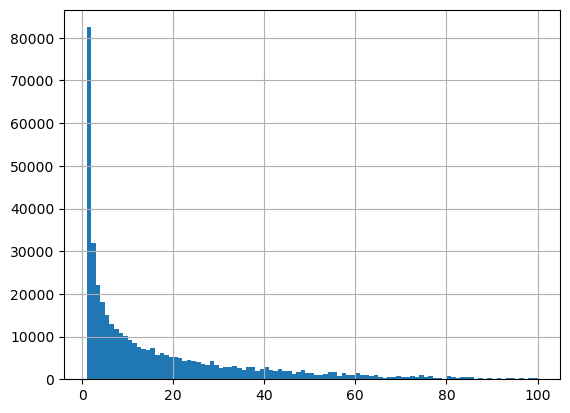

In [9]:
# plot the distribution of counts <= 100
df_add_count[df_add_count["ActorMovieCount"] <= 100]["ActorMovieCount"].hist(bins=99)

## 5. Group by actors

In this section, we group the dataframe by actor id, so that datapoints belonging to the same actor will be compressed into one row. The grouped dataframe will be used for modeling genre changes for each actor in the next section.

### filter out actors who played less than 5 movies

In [9]:
df_filtered = df_add_count[df_add_count["ActorMovieCount"] >= 5].copy()
df_filtered.shape[0]

259245

### drop duplicates

We notice that some actors played multiples characters in a single movie. Since **we only consider movie genres at this stage**, we **temporarily** drop duplicate datapoints and only keep the first character in a multiple rows.

In [10]:
# drop duplicates
df_dropdup = df_filtered.drop_duplicates(subset=["FID", "WID", "ActorID"]).copy()
df_dropdup.shape[0]

257264

### sort the dataframe by actor id and age
We first filter out actors without movie release date or age information.

In [11]:
# drop nan for both "movie_release_date" and "actor_age_at_movie_release"
df_dropna = df_dropdup.dropna(subset=["MovieReleaseDate", "ActorAgeAtMovieRelease"]).copy()
df_dropna.shape[0]

207283

In [12]:
# to make the dataframe more readable, we first sort by actor id to group the datapoints of the same actor together
# Then we sort age from small to large intra-actor.

df_sorted = df_dropna.sort_values(by=['ActorID', 'ActorAgeAtMovieRelease'], ascending=True, ignore_index=True).copy()
df_sorted.shape[0]

207283

### group the dataframe by actors

In [26]:
actor_groups = df_sorted.groupby("ActorID")

# convert series into list, the attributes are open to update
by_actor = actor_groups.apply(lambda x: pd.Series({"WID": x["WID"].values.tolist(),
                                                  "FID": x["FID"].values.tolist(),
                                                  "MovieReleaseDate": x["MovieReleaseDate"].values.tolist(),
                                                  "ActorGender": x["ActorGender"].iloc[0],
                                                  "ActorHeight": x["ActorHeight"].iloc[0],
                                                  "ActorAgeAtMovieRelease": x["ActorAgeAtMovieRelease"].values.tolist(),
                                                  "ActorName": x["ActorName"].iloc[0],
                                                  "ActorID": x["ActorID"].iloc[0],
                                                  "MovieName": x["MovieName"].values.tolist(),
                                                  "MovieBoxOfficeRevenue": x["MovieBoxOfficeRevenue"].values.tolist(),
                                                  "MovieLanguages": x["MovieBoxOfficeRevenue"].values.tolist(),
                                                  "MovieCountries": x["MovieCountries"].values.tolist(),
                                                  "MovieGenresFinal": x["MovieGenresFinal"].values.tolist(),
                                                  "AverageRating": x["AverageRating"].values.tolist(),
                                                  "NumVotes": x["NumVotes"].values.tolist(),
                                                  "Cannes": x["Cannes"].values.tolist(),
                                                  "Berlin": x["Berlin"].values.tolist(),
                                                  "Venice": x["Venice"].values.tolist(),
                                                  "OscarWinner": x["OscarWinner"].values.tolist(),
                                                  "OscarNomination": x["OscarNomination"].values.tolist(),
                                                  "ActorMovieCount": x["ActorMovieCount"].iloc[0]}))

## 6. Detect change with sliding window

In this section, we use a sliding window to detect changes of genres.

### define functions

In [47]:
def get_actor_id(actor_name, df):
    
    return df[df["ActorName"] == actor_name].index.tolist()[0]
    


def flatten_list(lst):
    """
    Convert a nested list to a flattened list.
    
    Parameters:
    - lst: a nested list whose elements are lists.
    
    Returns:
    - A list. 
    """
    flattened_list = []
    for sublist in lst:
        flattened_list += sublist
        
    return flattened_list


def argmax_list(lst):
    """
    Obtain the most common element(s) in a list.
    
    Parameters:
    - list: a list.
    
    Returns:
    - A list of unique elements with the highest frequency.
    """
    counter_obj = Counter(lst)
    most_common_elements = counter_obj.most_common()
    max_count = most_common_elements[0][1]
    most_common_items = [element for element, count in most_common_elements if count == max_count]
    
    return most_common_items


def check_same_freq(most_common, lst):

    return len(most_common) == len(set(lst))


def check_complete_change(lst1, lst2):
    
    return not bool(set(lst1) & set(lst2))


def jaccard_sim(set1, set2):
    
    return len((set(set1) & set(set2))) / len((set(set1)) | set(set2))


def detect_change(genre_list, hist_size=3, max_sim=0.25):
    
    n_change = 0
    history = []
    change_values = []
    
    # consider all the history
    if hist_size == -1:

        for movie_id, genres in enumerate(genre_list):
            
            if movie_id == 0:
                history.append(genres)
                change_values.append(0)
                continue

            if jaccard_sim(genres, flatten_list(history[:])) <= max_sim and jaccard_sim(genres, flatten_list(history[:])) >= 0:
                change_values.append(1)
            else:
                change_values.append(0)
            history.append(genres)

    elif hist_size > 0:
        
        for movie_id, genres in enumerate(genre_list):
            
            if movie_id == 0:
                history.append(genres)
                change_values.append(0)
                continue

            if jaccard_sim(genres, flatten_list(history[-hist_size:])) <= max_sim or jaccard_sim(genres, flatten_list(history[:])) == 0:
                change_values.append(1)
            else:
                change_values.append(0)
            history.append(genres)
    
    return change_values


def extract_window_values(genre_list, max_window_size=3):
    """
    Calculate the sliding window values for a list of genres.
    
    Parameters:
    - genre_list: list of lists, where each sublist contains genres of a movie.
    - window_size: integer, the size of the sliding window.
    
    Returns:
    - A tuple (window_values, argmax_types) where:
        - window_values: list of the most common genres (argmax) in each window.
    """
    initial_window_size = int(max_window_size - (max_window_size-1)/2) #This will store initial window_size
    window_values = []   # This will store the most common genres in each window
    
    # Start with the initial window size and increase until we reach the max window size
    for end in range(initial_window_size - 1, len(genre_list)):
        start = max(0, end - max_window_size)  # Determine the start of the window
        window_genres = flatten_list(genre_list[start:end])  # Flatten the genres within the window
        new_argmax_values = argmax_list(window_genres)  # Find the most common genres in the window

        window_values.append(new_argmax_values)

        # Once we reach the max window size, start moving the start of the window
        if (end-start) == max_window_size:
            start += 1

    # At the end, handle the last windows that are smaller than the max window size
    for window_size in range(max_window_size - 1, initial_window_size - 1, -1):
        start = len(genre_list) - window_size
        window_genres = flatten_list(genre_list[start:])
        new_argmax_values = argmax_list(window_genres)
        
        window_values.append(new_argmax_values)

    return window_values


def count_total_change(genre_list):
    """
    Count the number of total changes, where all genres are new.
    
    Parameters:
    - genre_list: list of lists (length > 1), where each sublist contains genres of a movie.
    
    Returns:
    - An integer that represents the number of total changes.
    """
    n_change = 0
    seen_genres = set()
    
    for movie_id, genres in enumerate(genre_list):
        # if accumulated genre is an empty list
        if movie_id == 0:
            for g in genres:
                seen_genres.add(g)
            continue
         
        curr_n = len(seen_genres)
        for g in genres:
            seen_genres.add(g)
        now_n = len(seen_genres)
        
        if now_n - curr_n == len(genres):
            n_change += 1
    
    return n_change


def extract_period_feature(window_value, window_change):
    """
    Extract 1-2 representative movie genres for each period
    
    Parameters:
    - window_value: list of lists (length > 1), where each sublist contains the movie genres of a window
    - window_change: list of change score of a window

    Returns:
    - A list of 1-2 representative movie genres for each period.
    """
    temp = []
    period_feature = []
    counter = 0
    for index in range(len(window_change)):
        change_score = window_change[index]
        if change_score == 1:
            if len(temp):
                string_counter = Counter(temp)
                if(len(string_counter) > 1):
                    most_common_string = [item[0] for item in string_counter.most_common(2)]
                else:
                    most_common_string = string_counter.most_common()[0][0]
                period_feature += [most_common_string] * counter
            temp.clear()
            counter = 0
        counter += 1
        temp += window_value[index]
        if index == len(window_change) - 1:
            if len(temp):
                string_counter = Counter(temp)
                if(len(string_counter) > 1):
                    most_common_string = [item[0] for item in string_counter.most_common(2)]
                else:
                    most_common_string = string_counter.most_common()[0][0]
                period_feature += [most_common_string] * counter
    return period_feature


def detect_change_an_actor(actor_id, df, window_size=3, hist_size=3, max_sim=0.25):

    # get the row from the dataframe
    row = df[df["ActorID"] == actor_id]
    
    # Calculate the relevant features of the sliding window
    window_value = extract_window_values(row["MovieGenresFinal"].iloc[0], max_window_size=window_size)
    window_change = detect_change(window_value, hist_size=hist_size, max_sim=max_sim)
    period_feature = extract_period_feature(window_value, window_change)
    
    # Prepare a new dataframe for this actor
    actor_changes = pd.DataFrame({"ActorName": row["ActorName"].iloc[0],
                                  "ActorID": row["ActorID"].iloc[0],
                                  "MovieName": row["MovieName"].iloc[0],
                                  "MovieReleaseDate": row["MovieReleaseDate"].iloc[0],
                                  "Genres": row["MovieGenresFinal"].iloc[0],
                                  "AverageRating": row["AverageRating"].iloc[0],
                                  "NumVote": row["NumVotes"].iloc[0],
                                  "MovieBoxOfficeRevenue": row["MovieBoxOfficeRevenue"].iloc[0],
                                  "ActorGender": row["ActorGender"].iloc[0],
                                  "ActorAge": row["ActorAgeAtMovieRelease"].iloc[0],
                                  "Cannes": row["Cannes"].iloc[0],
                                  "Berlin": row["Berlin"].iloc[0],
                                  "Venice": row["Venice"].iloc[0],
                                  "OscarWinner": row["OscarWinner"].iloc[0],
                                  "OscarNomination": row["OscarNomination"].iloc[0]})
    
    actor_changes["WindowValues"] = window_value
    actor_changes["WindowChange"] = window_change
    actor_changes["PeriodFeature"] = period_feature
    
    return actor_changes

In [51]:
# apply sliding window to one actor as an example
actor_name = "Meryl Streep"
actor_id = get_actor_id(actor_name, by_actor)
df1 = detect_change_an_actor(actor_id, by_actor, window_size=3, hist_size=1, max_sim=0.25)
df1["ChangeCounts"] = df1["WindowChange"].eq(1).sum()
display(df1[["MovieName", "Genres", "WindowValues", "PeriodFeature", "ChangeCounts"]])

,MovieName,Genres,WindowValues,PeriodFeature,ChangeCounts
0,Julia,[Drama],[Drama],Drama,13
1,Uncommon Women and Others,[Drama],[Drama],Drama,13
2,The Deer Hunter,[War film],[Drama],Drama,13
3,Kramer vs. Kramer,[Drama],[Drama],Drama,13
4,Manhattan,"[Comedy, Romance]","[War film, Drama, Comedy, Romance]","[War film, Drama]",13
5,The Seduction of Joe Tynan,[Comedy],[Comedy],Comedy,13
6,Still of the Night,"[Crime, Detective, Thriller]",[Comedy],Comedy,13
7,Sophie's Choice,[Romance],"[Comedy, Crime, Detective, Thriller, Romance]","[Comedy, Crime]",13
8,Falling in Love,[Romance],[Romance],Romance,13
9,Silkwood,[Thriller],[Romance],Romance,13


In [52]:
# apply sliding window to ALL actors
characters_movies_add_change = None

for actor_id in tqdm(by_actor.ActorID.values):
    df1 = detect_change_an_actor(actor_id, by_actor, window_size=3, hist_size=1, max_sim=0.25)
    df1["ChangeCounts"] = df1["WindowChange"].eq(1).sum()
    characters_movies_add_change = pd.concat([characters_movies_add_three_cols, df1], axis=0, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████| 15001/15001 [07:32<00:00, 33.15it/s]


In [53]:
characters_movies_add_change.to_pickle("characters_movies_add_change.pkl")

# 7. Descriptive statistics of number of changes

In [4]:
df_change = pd.read_pickle("characters_movies_add_change.pkl")
df_change.head()

,ActorName,ActorID,MovieName,MovieReleaseDate,Genres,AverageRating,NumVote,MovieBoxOfficeRevenue,ActorGender,ActorAge,Cannes,Berlin,Venice,OscarWinner,OscarNomination,WindowValues,WindowChange,PeriodFeature,ChangeCounts
0,Adam Carolla,/m/010p3,Hairshirt,0,"[Comedy, Romance]",NaN,NaN,NaN,M,33.0,0,0,0,0,0,"[Comedy, Romance]",0,"[Comedy, Romance]",0
1,Adam Carolla,/m/010p3,Splendor,0,[Comedy],NaN,NaN,NaN,M,34.0,0,0,0,0,0,[Comedy],0,"[Comedy, Romance]",0
2,Adam Carolla,/m/010p3,Down to You,2000,"[Comedy, Romance]",5.0,15579.0,24419914.0,M,35.0,0,0,0,0,0,[Comedy],0,"[Comedy, Romance]",0
3,Adam Carolla,/m/010p3,After Sex,0,"[Comedy, Romance]",NaN,NaN,NaN,M,35.0,0,0,0,0,0,[Comedy],0,"[Comedy, Romance]",0
4,Adam Carolla,/m/010p3,Windy City Heat,0,[Comedy],NaN,NaN,NaN,M,38.0,0,0,0,0,0,[Comedy],0,"[Comedy, Romance]",0


In [5]:
# group by ChangeCounts
grouped_data = df_change.groupby('ChangeCounts')

# create a dictionary, each row includes all datapoints of the same count of changes
groups = {group: grouped_data.get_group(group) for group in grouped_data.groups}

# Calculate the number of male and female actors in each 'ChangeCounts' group
actor_gender_counts = df_change.groupby(['ChangeCounts', 'ActorGender'])['ActorID'].nunique().unstack()

# show results
actor_gender_counts.head(30)

ActorGender,F,M
ChangeCounts,,
0,1162.0,2047.0
1,1399.0,2271.0
2,982.0,1614.0
3,586.0,1030.0
4,361.0,662.0
5,249.0,412.0
6,193.0,328.0
7,138.0,220.0
8,98.0,167.0


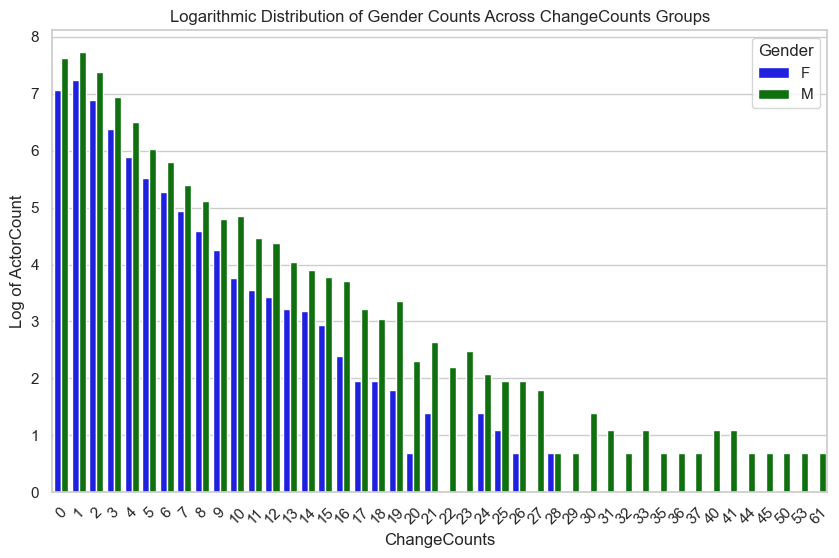

In [6]:
# groupby ChangeCounts and ActorGender and calculate the number of actors within each group
actor_gender_counts = df_change.groupby(['ChangeCounts', 'ActorGender'])['ActorID'].nunique().reset_index(name='ActorCount')
# Logarithmic conversion of ActorCount
actor_gender_counts['LogActorCount'] = np.log1p(actor_gender_counts['ActorCount'])  # Use log1p to avoid taking logarithms of 0.

#Charting with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='ChangeCounts', y='LogActorCount', hue='ActorGender', data=actor_gender_counts, palette=['blue', 'green'])
plt.title('Logarithmic Distribution of Gender Counts Across ChangeCounts Groups')
plt.xlabel('ChangeCounts')
plt.ylabel('Log of ActorCount')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

The provided bar chart illustrates the logarithmic distribution of actor counts by gender across different groups defined by the number of role changes (ChangeCounts). Here's an analysis based on the visual representation:

Role Change Frequency:

The ChangeCounts on the x-axis likely represents the number of times actors have changed roles or the diversity of roles they have played. The values are spread out along the x-axis, with a higher concentration of bars towards the left side, indicating that most actors have fewer role changes, while fewer actors have a higher number of role changes.
Gender Distribution:

The bars are colored by gender, with blue representing female (F) actors and green representing male (M) actors. The distribution shows a higher number of male actors across all ChangeCounts categories as indicated by the green bars, suggesting that male actors tend to have more diverse roles or more frequent role changes compared to female actors.
Logarithmic Scale Interpretation:

The y-axis displays the logarithm of the actor count, which helps to manage the wide range of values and highlight differences across orders of magnitude. A logarithmic scale is particularly useful in data sets with a heavy-tailed distribution, where most of the data points are clustered around the lower end of the range.
Trend Analysis:

Both genders show a decreasing trend in actor counts as ChangeCounts increase, but this decrease is more rapid for female actors. This might suggest that while both male and female actors have fewer high-frequency role changes, this phenomenon is more pronounced among females.
Interpretation of Data Spread:

The graph shows a general trend that as the number of role changes increases, the number of actors (both male and female) decreases. This is consistent with the expectation that not many actors have a vast diversity of roles in their careers.
In summary, the chart highlights potential disparities in the acting industry, with male actors exhibiting a higher frequency of role changes across the spectrum compared to female actors. The use of a logarithmic scale on the actor counts enables us to discern the distribution more clearly, even where there are large differences in the number of actors between different ChangeCounts groups.

Exploring the Impact of Gender and Reputation on Role Diversity in the Film Industry
In this analysis, we delve into how an actor's gender and reputation, as indicated by Oscar recognition, influence the variety of roles they play. Our goal is to uncover potential trends and disparities in the film industry, particularly focusing on role diversity.

Creating a Reputation Metric
We define an actor's reputation based on their association with the Oscars - either as a winner or a nominee. A new column, HighReputation, is created in the dataset where:

HighReputation is set to 1 (high) if the actor has either won or been nominated for an Oscar.
HighReputation is set to 0 (low) otherwise.
This distinction allows us to compare actors with high industry recognition against those with lower or no Oscar-related accolades.

Analyzing Role Transition Frequencies
Our primary measure of role diversity is the ChangeCounts, which represents the frequency of changes in the types of roles an actor plays. We calculate the average ChangeCounts for each subgroup formed by gender (ActorGender) and reputation (HighReputation).

Visualization Approach
Plot Type: Bar Plot.
X-axis: Represents the gender of the actors.
Y-axis: Shows the average ChangeCounts, indicating the average frequency of role changes.
Hue: Differentiates between actors with high and low reputation.
Insights from the Plot
By examining the bar plot, we aim to understand:

Whether gender influences an actor's likelihood to diversify their roles.
The impact of having high recognition (like an Oscar nomination or win) on an actor's career flexibility and role variety.
The results of this analysis can shed light on patterns and biases in role allocation within the film industry, contributing to discussions around diversity and representation in cinema.

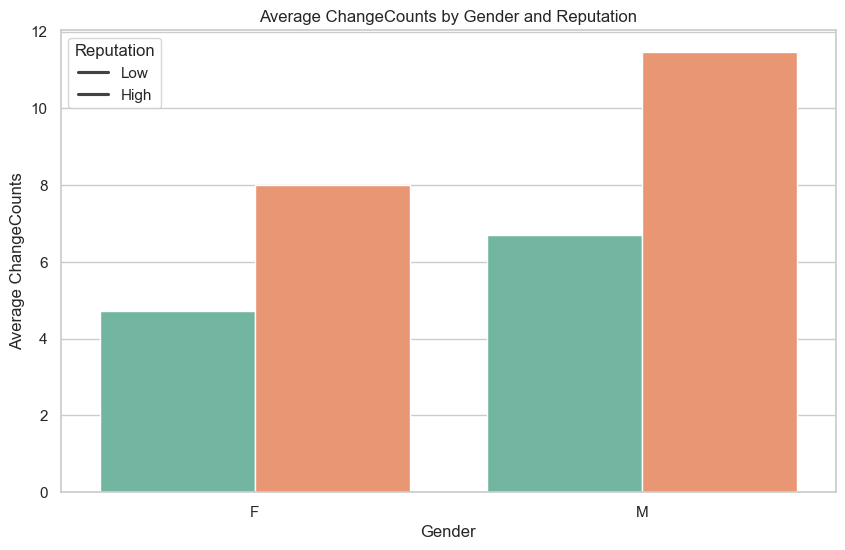

In [7]:
# Create a new column indicating reputation (OscarWinner or OscarNomination is considered high if either is 1)
df_change['HighReputation'] = df_change.apply(lambda x: 1 if x['OscarWinner'] == 1 or x['OscarNomination'] == 1 else 0, axis=1)

# Calculate the average number of transitions for each gender and reputation subgroup
grouped_data = df_change.groupby(['ActorGender', 'HighReputation'])['ChangeCounts'].mean().reset_index()

# Drawing bar graphs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='ActorGender', y='ChangeCounts', hue='HighReputation', data=grouped_data, palette='Set2')
plt.title('Average ChangeCounts by Gender and Reputation')
plt.xlabel('Gender')
plt.ylabel('Average ChangeCounts')
plt.legend(title='Reputation', labels=['Low', 'High'])
plt.show()

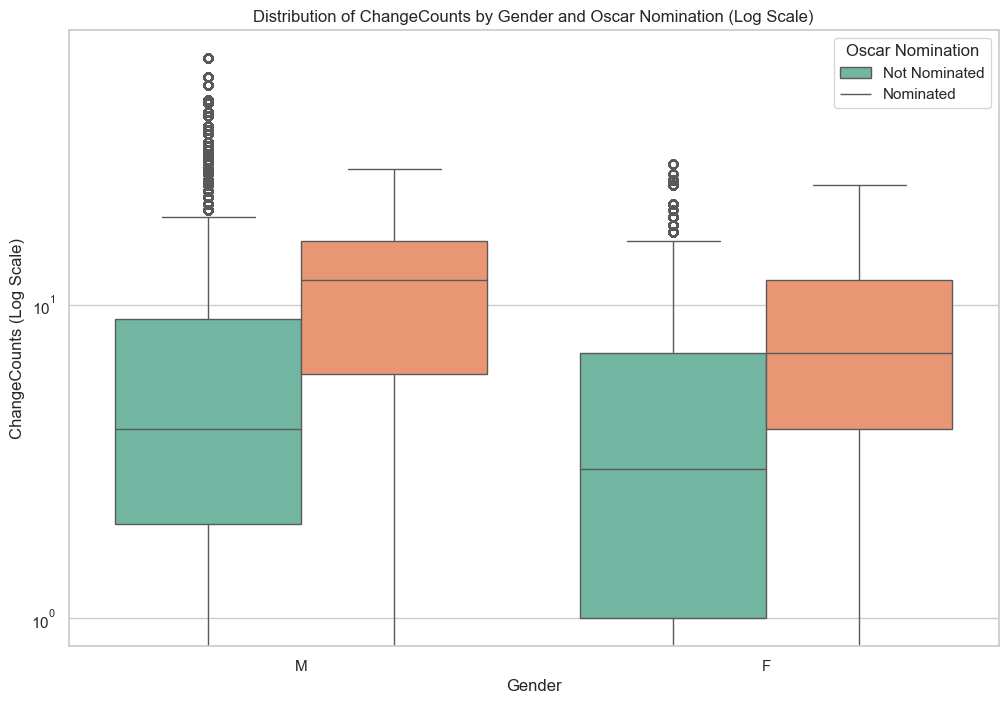

In [8]:
# Plotting box plots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(x='ActorGender', y='ChangeCounts', hue='HighReputation', data=df_change, palette='Set2')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.title('Distribution of ChangeCounts by Gender and Oscar Nomination (Log Scale)')
plt.xlabel('Gender')
plt.ylabel('ChangeCounts (Log Scale)')
plt.legend(title='Oscar Nomination', labels=['Not Nominated', 'Nominated'])
plt.show()

The provided box plot ChangeCounts for actors based on two factors: gender (Male or Female) and Oscar nomination status (Nominated or Not Nominated). The y-axis is on a logarithmic scale, which allows for a more nuanced view of the data across a wide range of values.

Here are some detailed observations and analysis based on the box plot:

Gender Differences: There are observable differences between the distributions of male and female actors' role changes. It appears that the median value of role changes for males is slightly higher than for females, suggesting that on average, male actors may experience more role variety or career changes than their female counterparts.

Impact of Oscar Nomination:

Male Actors: For male actors, there is a noticeable difference in the role change counts between those who have been nominated for an Oscar and those who have not. Nominated male actors tend to have a wider interquartile range (IQR) and higher median, indicating more variability and a higher average number of role changes.
Female Actors: Female actors show a similar pattern, where those who have been nominated for an Oscar also have a wider IQR and higher median compared to those who have not been nominated. This suggests that Oscar-nominated female actors also tend to have a higher average number of role changes.
Outliers: The plot shows several outliers for both genders and nomination statuses, indicating that there are actors who have role change counts significantly higher than the general population. This could be indicative of highly versatile actors or those who have had unusually diverse career paths.

Logarithmic Scale: The use of a logarithmic scale on the y-axis indicates that the data spans multiple orders of magnitude. This suggests that while many actors have relatively few role changes, there is a subset of actors with a significantly higher number of changes.

Interpretation of Reputation: The wider spread and higher median of role changes for Oscar-nominated actors could imply that a high reputation within the industry, as signified by Oscar recognition, is associated with a more diverse range of roles. However, it could also reflect that actors who have more varied roles are more likely to be noticed and nominated for Oscars.

In summary, the box plot indicates that gender and Oscar nomination status may both be factors in the diversity of roles an actor plays. Actors with an Oscar nomination, regardless of gender, tend to have a higher frequency of role changes. The variability in role changes is also greater among Oscar-nominated actors, which could point towards the complexity of career trajectories for actors achieving high recognition in the film industry.